In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'uci-bag-of-words:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2180053%2F3639953%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240712%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240712T155955Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6d399dc030f8e8f8071a88be6058f0b9661f2d5f15e35895db081b1089f8fa92e60674ff1f8929228a17c125ba4e111476f79061edf65fb41a056a3d7ece5f4fb74e1ab4acb7cf7fe16649b8d60c4c94ed5f96a27ef380d1bb52de2ab0e036de54cba4e3cf16063f3b58250ac6e52c1b0ff08265842dae90a37750a0cadebe219408c8cca4c3000ae55981484eac758a765c6d382bb1a8a9e1143b0574f280820910af8bcfd46bb16d6401977f38cfe1b66dfd673caf082730ba3dc5f7b2756f6a03f5e3c2e20a6a3a11e5b863ede57cbf900c0b1da23d338958a42ba9bf1e35c2278709584636f552fd3bf4f0f5cd98ee6a19e49fda7c35776322048d58cb41'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


**Task 1: Working with Bag of Words Dataset**

In [ ]:
#Importing important and necessary libraries
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import random

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
class DatasetLoader:
    def __init__(self, data_paths):
        self.data_paths = data_paths

    def load_dataset(self, dataset_name, doc_limit=None):
        docword_path = self.data_paths[dataset_name]['docword']
        vocab_path = self.data_paths[dataset_name]['vocab']

        docword = pd.read_csv(docword_path, header=None, names=['docID', 'wordID', 'count'], skiprows=3, sep=' ')
        vocab = pd.read_csv(vocab_path, header=None, names=['word']).fillna('null')
        vocab['wordID'] = vocab.index + 1

        if doc_limit:
            doc_ids = random.sample(list(set(docword['docID'])), k=doc_limit)
            docword = docword[docword['docID'].isin(doc_ids)].reset_index(drop=True)

        return docword, vocab

    def combine_datasets(self, datasets):
        dfs = []
        offset = 0
        for df, vocab in datasets:
            ids = df['docID'] + offset
            df['new_id'] = ids
            offset = ids.max()
            df = df.merge(vocab)[['new_id', 'word', 'count']]
            dfs.append(df)

        merged = pd.concat(dfs, ignore_index=True).rename(columns={'new_id': 'docID'})
        merged_vocab = pd.DataFrame({'word': merged['word'].unique()}).reset_index().rename(columns={'index': 'wordID'})
        merged = merged.merge(merged_vocab, how='left')
        merged = merged[['docID', 'wordID', 'count']].sort_values(['docID', 'wordID']).reset_index(drop=True)

        return merged, merged_vocab

In [ ]:
# Define paths to datasets
data_paths = {
    'enron': {
        'docword': '../input/uci-bag-of-words/docword.enron.txt',
        'vocab': '../input/uci-bag-of-words/vocab.enron.txt'
    },
    'kos': {
        'docword': '../input/uci-bag-of-words/docword.kos.txt',
        'vocab': '../input/uci-bag-of-words/vocab.kos.txt'
    },
    'nips': {
        'docword': '../input/uci-bag-of-words/docword.nips.txt',
        'vocab': '../input/uci-bag-of-words/vocab.nips.txt'
    }
}

In [ ]:
# Instantiate and load datasets
loader = DatasetLoader(data_paths)
enron, enron_vocab = loader.load_dataset('enron', doc_limit=6000)
kos, kos_vocab = loader.load_dataset('kos')
nips, nips_vocab = loader.load_dataset('nips')

In [ ]:
# Combine datasets
merged, merged_vocab = loader.combine_datasets([(enron, enron_vocab), (kos, kos_vocab), (nips, nips_vocab)])

# Create word-document matrix
wdm = merged.pivot(index='wordID', columns='docID', values='count').fillna(0.0).astype(pd.SparseDtype("float", 0.0))


In [ ]:
# Truncated SVD
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
y_svd = svd.fit_transform(wdm)

# Top dimensions analysis
wordsSVD = pd.DataFrame(y_svd, index=merged_vocab['word'])

In [ ]:
for index in range(10):
    thrsh = wordsSVD.loc[:, index].quantile(0.9)
    print(f"Dimension: {index}")
    words = list(wordsSVD[wordsSVD[index] > thrsh].sort_values([index], ascending=False).index)[:25]
    print(words)
    print()

Dimension: 0
['network', 'model', 'learning', 'input', 'function', 'neural', 'set', 'unit', 'data', 'training', 'algorithm', 'system', 'output', 'weight', 'error', 'problem', 'result', 'number', 'method', 'parameter', 'pattern', 'neuron', 'vector', 'point', 'layer']

Dimension: 1
['power', 'company', 'energy', 'california', 'electricity', 'billion', 'firm', 'market', 'companies', 'davis', 'plan', 'bill', 'business', 'utility', 'states', 'prices', 'project', 'plant', 'cost', 'price', 'utilities', 'month', 'customer', 'percent', 'official']

Dimension: 2
['network', 'unit', 'input', 'neural', 'output', 'weight', 'layer', 'hidden', 'company', 'net', 'training', 'firm', 'pattern', 'connection', 'recurrent', 'neuron', 'architecture', 'fund', 'activation', 'round', 'ventures', 'trained', 'partner', 'capital', 'investor']

Dimension: 3
['model', 'neuron', 'cell', 'input', 'visual', 'system', 'response', 'signal', 'object', 'field', 'motion', 'activity', 'firing', 'direction', 'synaptic', 'sti

In [ ]:
# Cosine similarity analysis
def calculate_cosine_similarity(docword):
    wdm = docword.pivot(index='docID', columns='wordID', values='count').fillna(0).astype(pd.SparseDtype("int16", 0))
    sims = cosine_similarity(wdm, dense_output=False)
    return sims.mean()

average_cosine_similarities = []
average_cosine_similarities.append(("enron", calculate_cosine_similarity(enron)))
average_cosine_similarities.append(("kos", calculate_cosine_similarity(kos)))
average_cosine_similarities.append(("nips", calculate_cosine_similarity(nips)))

doc_term_mat = merged.pivot(index='docID', columns='wordID', values='count').fillna(0).astype(pd.SparseDtype("int16", 0))
sims = cosine_similarity(doc_term_mat, dense_output=False)
average_cosine_similarities.append(("all", sims.mean()))

cosine_sims_df = pd.DataFrame(average_cosine_similarities, columns=['corpus', "average_cosine_similarity"])
print(cosine_sims_df)

  corpus  average_cosine_similarity
0  enron                   0.024761
1    kos                   0.080545
2   nips                   0.177767
3    all                   0.026527


In [ ]:
# LSA for clustering
dtm = wdm.T

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
x_lsa = lsa.fit_transform(dtm)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance (LSA): {explained_variance * 100:.2f}%")

Explained variance (LSA): 56.49%


In [ ]:
# Using DBSCAN model for clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
labels = dbscan.fit_predict(x_lsa)

dtm['label'] = labels
for cluster in range(-1, max(labels)+1):
    print(f"Cluster: {cluster}")
    cluster_docs = dtm[dtm['label'] == cluster]
    top_ten_words = set(cluster_docs.sum().sort_values(ascending=False).head(10).index)
    print(merged_vocab[merged_vocab['wordID'].isin(top_ten_words)]['word'].tolist())
    print()


Cluster: -1
['addition', 'emshwiller', 'lessened', 'lowercost', 'mammoth', 'marketoriented', 'senates', 'sopranos', 'statesponsored', 'tenet']

Cluster: 0
['data', 'set', 'function', 'network', 'model', 'input', 'learning', 'neural', 'algorithm', 'system']



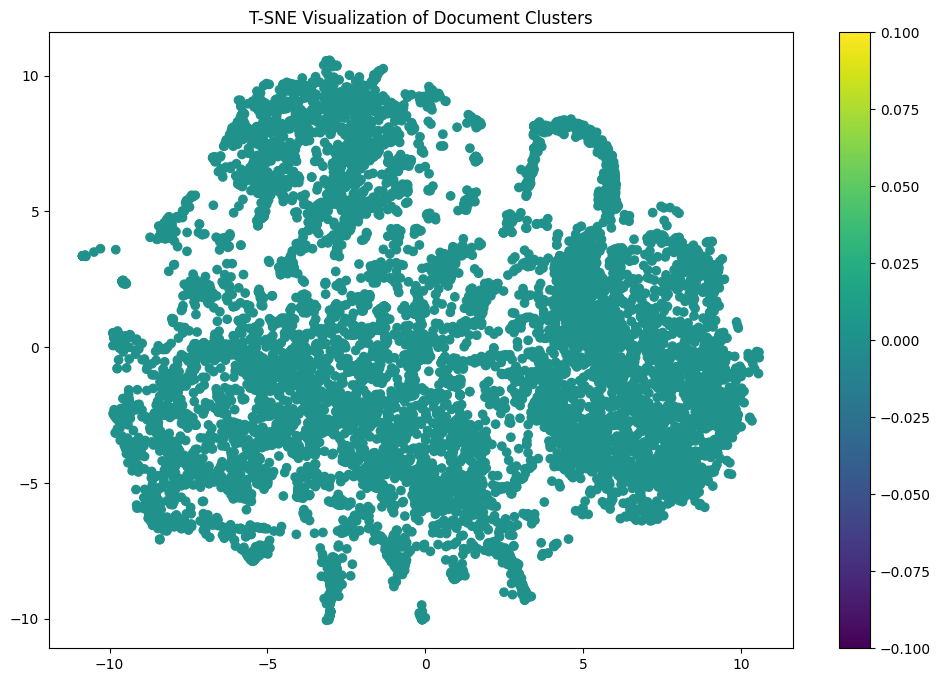

In [ ]:
# T-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
x_tsne = tsne.fit_transform(x_lsa)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='viridis', marker='o')
plt.colorbar(scatter)
plt.title("T-SNE Visualization of Document Clusters")
plt.show()

In [ ]:
# PCA for clustering
tdm = merged.pivot(index='wordID', columns='docID', values='count').fillna(0.0)
pca = PCA(n_components=100)
y_pca = pca.fit_transform(tdm)

word_pca = pd.DataFrame(y_pca, index=merged_vocab['word'])

In [ ]:
explained_variance_pca = pca.explained_variance_ratio_.sum()
print(f"Explained variance (PCA): {explained_variance_pca * 100:.2f}%")

for index in range(10):
    thrsh = word_pca.loc[:, index].quantile(0.9)
    print(f"Dimension: {index}")
    words = list(word_pca[word_pca[index] > thrsh].sort_values([index], ascending=False).index)[:25]
    print(words)
    print()

Explained variance (PCA): 57.44%
Dimension: 0
['network', 'model', 'learning', 'input', 'function', 'neural', 'set', 'unit', 'data', 'training', 'algorithm', 'system', 'output', 'weight', 'error', 'problem', 'result', 'number', 'method', 'parameter', 'pattern', 'neuron', 'vector', 'point', 'layer']

Dimension: 1
['power', 'company', 'energy', 'california', 'electricity', 'billion', 'firm', 'market', 'companies', 'davis', 'plan', 'bill', 'business', 'utility', 'states', 'prices', 'project', 'plant', 'cost', 'utilities', 'price', 'month', 'customer', 'percent', 'official']

Dimension: 2
['network', 'unit', 'input', 'neural', 'output', 'weight', 'layer', 'hidden', 'company', 'net', 'training', 'pattern', 'firm', 'connection', 'recurrent', 'neuron', 'architecture', 'fund', 'activation', 'round', 'ventures', 'trained', 'partner', 'capital', 'investor']

Dimension: 3
['model', 'neuron', 'cell', 'input', 'visual', 'system', 'response', 'signal', 'object', 'field', 'motion', 'activity', 'firin